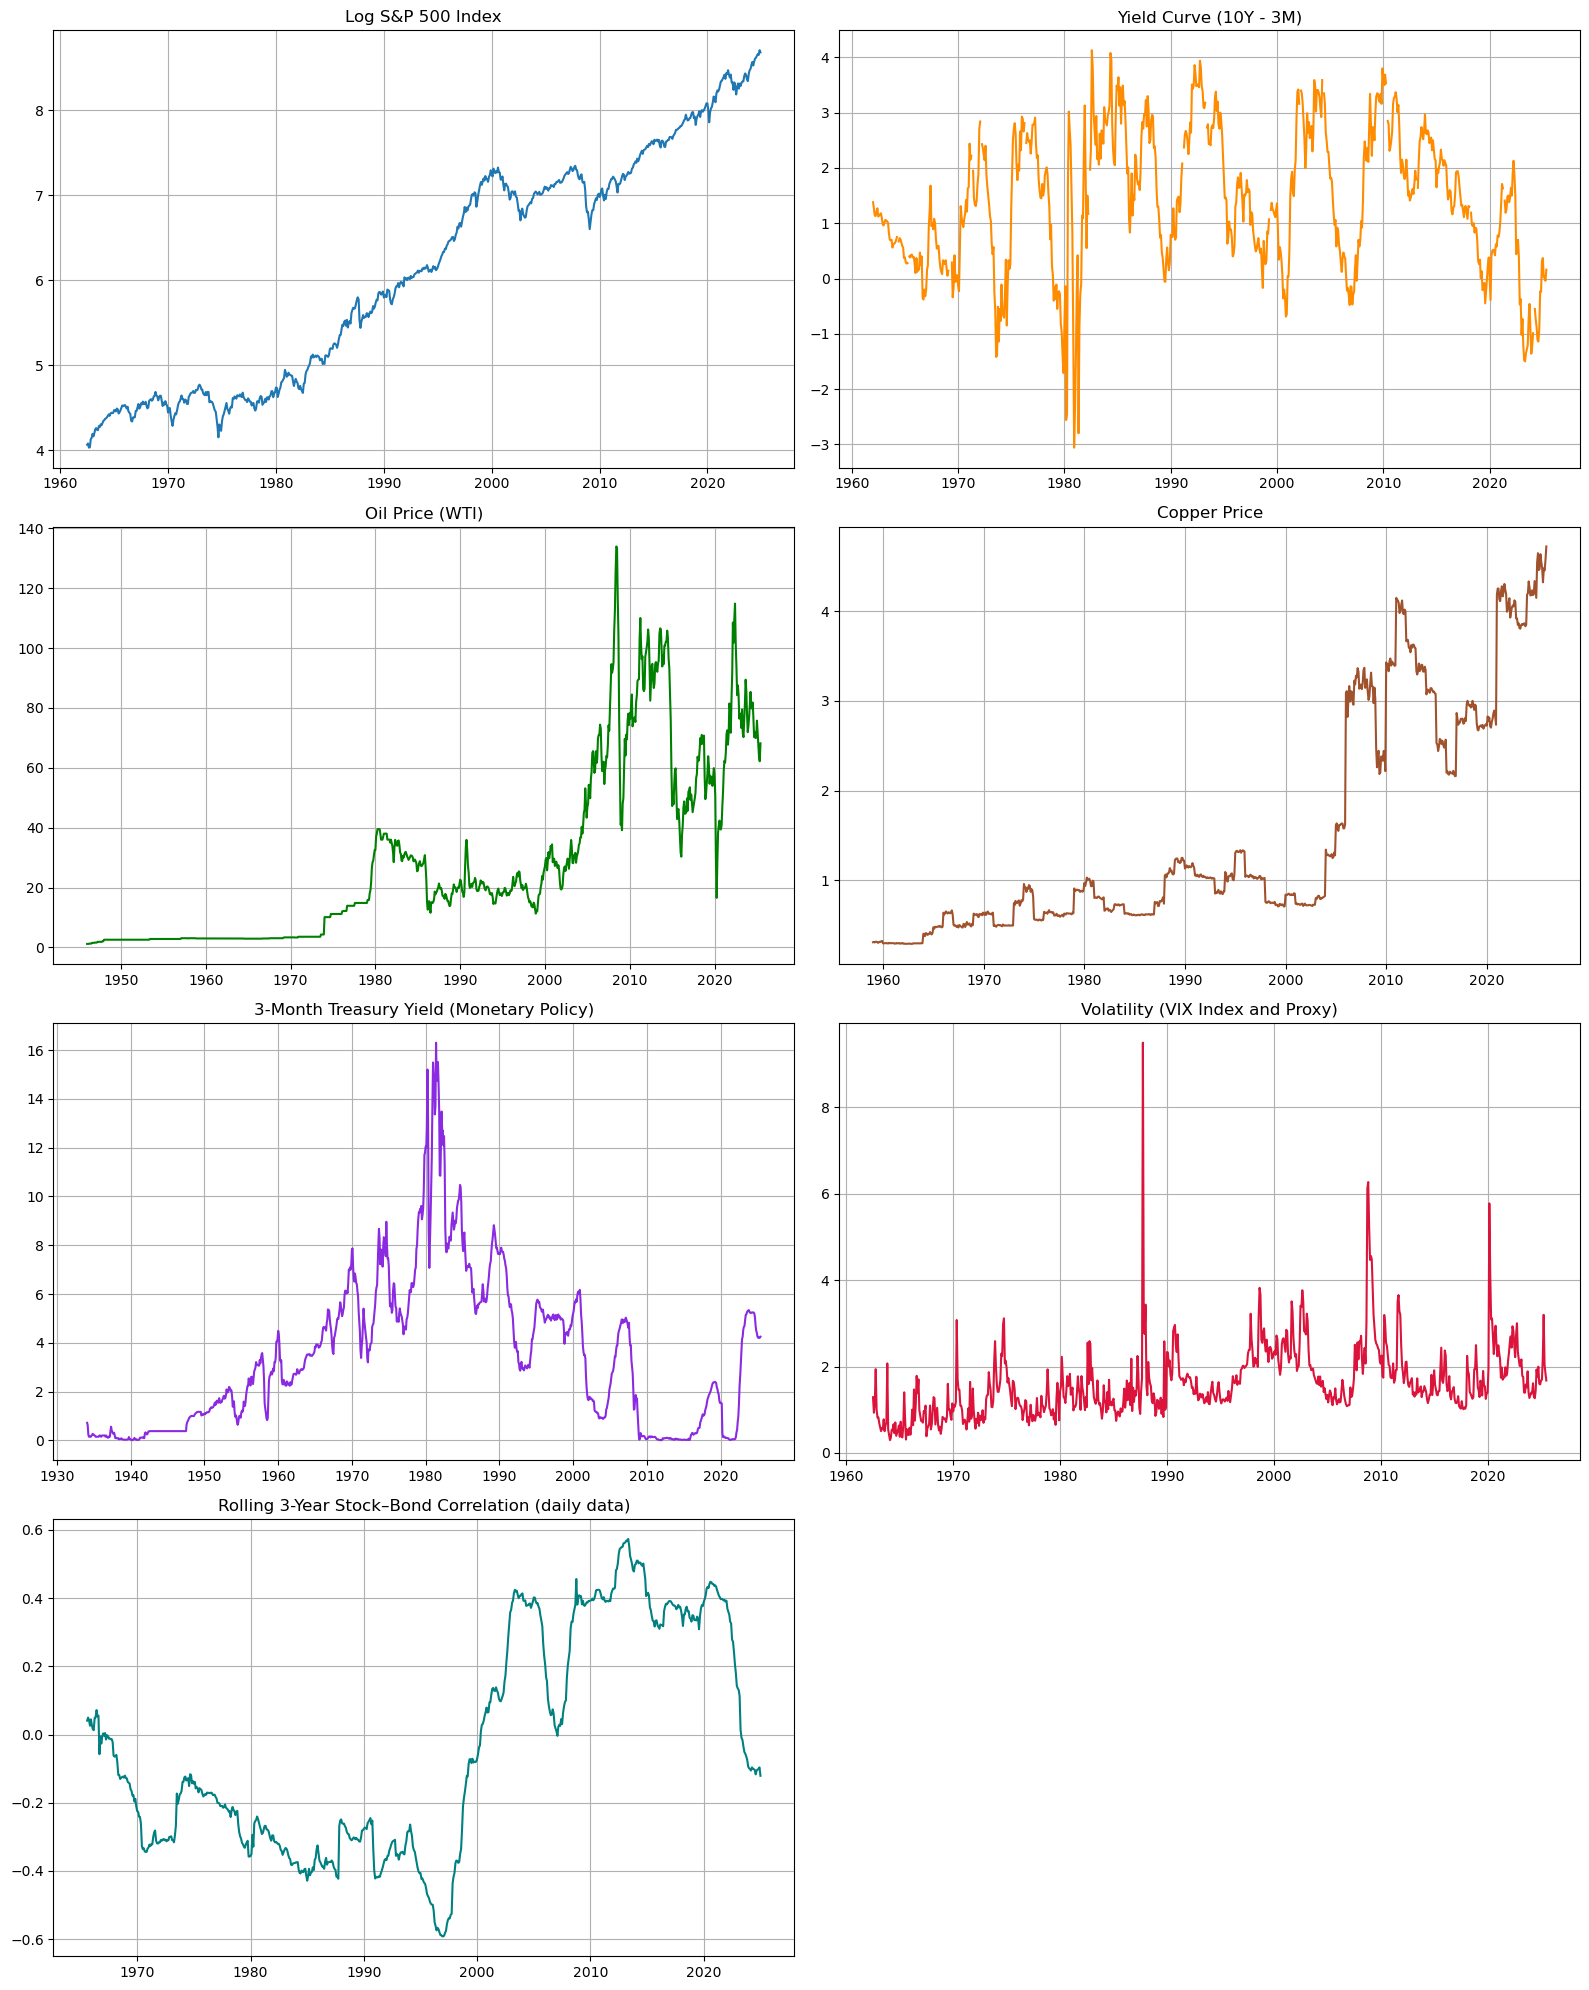

In [104]:
import pandas as pd
import numpy  as np
import matplotlib.pyplot as plt
import matplotlib.dates   as mdates
import seaborn            as sns

to_ts = lambda p: p.to_timestamp(how="end")

# ======================================================================
# 1.  S&P 500  (daily ➜ monthly prices & returns)
# ======================================================================
sp_daily = (pd.read_csv(r"C:\Users\kelvi\Downloads\i6ar9ozj9pp0lqfk.csv",
                        usecols=["DlyCalDt", "DlyPrcInd"])
              .rename(columns={"DlyCalDt": "Date",
                               "DlyPrcInd": "SP500_Price"}))
sp_daily["Date"] = pd.to_datetime(sp_daily["Date"])

sp_daily["ret"]  = np.log(sp_daily["SP500_Price"]).diff()

sp_daily["Month"] = sp_daily["Date"].dt.to_period("M")
sp_monthly = (sp_daily
              .groupby("Month")
              .tail(1)          
              .reset_index(drop=True))

sp_monthly["SP500_Return"] = np.log(sp_monthly["SP500_Price"]).diff()
sp_monthly["Log_SP500"]    = np.log(sp_monthly["SP500_Price"])

var_mkt = sp_monthly[["Month", "SP500_Price",
                      "SP500_Return", "Log_SP500"]].copy()

# ======================================================================
# 2.  10-YEAR YIELD  (daily ➜ monthly)
# ======================================================================
bond_daily = (pd.read_csv(r"C:\Users\kelvi\Downloads\DGS10.csv",
                          usecols=["observation_date", "DGS10"])
                .rename(columns={"observation_date": "Date",
                                 "DGS10": "TenYear"}))
bond_daily["Date"] = pd.to_datetime(bond_daily["Date"])
bond_daily["TenYear"] = pd.to_numeric(bond_daily["TenYear"],
                                      errors="coerce")

bond_daily["Month"]  = bond_daily["Date"].dt.to_period("M")
tenyear_monthly = (bond_daily
                   .groupby("Month")
                   .tail(1)              # month-end value
                   .reset_index(drop=True)
                   [["Month", "TenYear"]])

# ======================================================================
# 3.  3-MONTH BILL (monthly, unchanged)
# ======================================================================
var_3m = (pd.read_csv(r"C:\Users\kelvi\Downloads\TB3MS.csv",
                      usecols=["observation_date", "TB3MS"])
            .rename(columns={"observation_date": "Date",
                             "TB3MS": "ThreeMonth"}))
var_3m["Date"]  = pd.to_datetime(var_3m["Date"])
var_3m["ThreeMonth"] = pd.to_numeric(var_3m["ThreeMonth"], errors="coerce")
var_3m["Month"] = var_3m["Date"].dt.to_period("M")
var_3m = var_3m[["Month", "ThreeMonth"]]

# ======================================================================
# 4.  YIELD-CURVE VARIABLES  (10y − 3m, Δ10y)
# ======================================================================
merged = (tenyear_monthly
          .merge(var_3m, on="Month", how="inner")
          .sort_values("Month"))

merged["YieldCurve"]  = merged["TenYear"] - merged["ThreeMonth"]
merged["YieldChange"] = merged["TenYear"].diff()

# ======================================================================
# 5.  OIL  (unchanged: monthly average)
# ======================================================================
var_oil = (pd.read_csv(r"C:\Users\kelvi\Downloads\WTISPLC.csv")
             .rename(columns={"observation_date": "Date",
                              "WTISPLC": "Oil Price"}))
var_oil["Date"] = pd.to_datetime(var_oil["Date"])
var_oil["Oil Price"] = pd.to_numeric(var_oil["Oil Price"], errors="coerce")
var_oil["Month"] = var_oil["Date"].dt.to_period("M")
oil_monthly = (var_oil
               .groupby("Month")["Oil Price"]
               .mean()
               .reset_index())

# ======================================================================
# 6.  COPPER  (unchanged: monthly average)
# ======================================================================
var_copper = pd.read_csv(
    r"C:\Users\kelvi\Downloads\copper-prices-historical-chart-data.csv")
var_copper.rename(columns={var_copper.columns[0]: "Date",
                           var_copper.columns[1]: "Copper"},
                  inplace=True)
var_copper["Date"]   = pd.to_datetime(var_copper["Date"],
                                      dayfirst=True, errors="coerce")
var_copper["Copper"] = pd.to_numeric(var_copper["Copper"], errors="coerce")
var_copper["Month"]  = var_copper["Date"].dt.to_period("M")
copper_monthly = (var_copper
                  .groupby("Month")["Copper"]
                  .mean()
                  .reset_index())


# ======================================================================
# 7.  VIX (daily ➜ monthly)  +  REALISED-VOL PROXY (daily pre-1990)
# ======================================================================
# --- 7a. Bloomberg VIX (daily)  ---------------------------------------
var_VIX = (pd.read_excel(r"C:\Users\kelvi\Downloads\VIX.xlsx",
                         usecols=["Dates", "PX_LAST"])
             .rename(columns={"Dates": "Date", "PX_LAST": "VIX"}))
var_VIX["Date"] = pd.to_datetime(var_VIX["Date"])
var_VIX["VIX"]  = pd.to_numeric(var_VIX["VIX"], errors="coerce")

var_VIX["Month"] = var_VIX["Date"].dt.to_period("M")
vix_monthly = (var_VIX
               .groupby("Month")["VIX"]
               .mean()
               .div(10)
               .rename("VolProxy")  
               .reset_index())

# --- 7b. Realised volatility from DAILY S&P 500 returns ---------------
first_vix_month = vix_monthly["Month"].min()

realised = (
    sp_daily
      .loc[sp_daily["Month"] < first_vix_month]
      .groupby("Month")["ret"]
      .agg(lambda x: x.std(ddof=0) * np.sqrt(252) * 10)
      .to_frame("VolProxy")
      .reset_index()
)
# --- 7c. Stitch realised-vol with VIX ---------------------------------
combined_vol = (pd.concat([realised, vix_monthly], axis=0)
                  .sort_values("Month")
                  .reset_index(drop=True))

# ======================================================================
# 8.  STOCK–BOND CORRELATION  (daily ➜ monthly, paper’s method)
# ======================================================================
df_daily = (sp_daily[["Date", "ret"]]
              .merge(bond_daily[["Date", "TenYear"]], on="Date",
                     how="inner")
              .dropna())
df_daily["d_y"] = df_daily["TenYear"].diff() / 100.0
df_daily.dropna(inplace=True)

window_days = 252 * 3
df_daily["StockBondCorr"] = (df_daily["ret"]
                               .rolling(window_days)
                               .corr(df_daily["d_y"]))

df_daily["Month"] = df_daily["Date"].dt.to_period("M")
var_correl = (df_daily.dropna(subset=["StockBondCorr"])
                .groupby("Month")
                .tail(1)
                [["Month", "StockBondCorr"]]
                .reset_index(drop=True))

fig, axes = plt.subplots(4, 2, figsize=(16, 20))
fig.subplots_adjust(hspace=0.4, wspace=0.3)
axes = axes.flatten()  

# 1. Log S&P500
var_mkt_latest = var_mkt.drop_duplicates('Month', keep='last')
axes[0].plot(var_mkt_latest['Month'].dt.to_timestamp(), 
             np.log(var_mkt_latest['SP500_Price']), label='Log S&P 500')
axes[0].set_title("Log S&P 500 Index")
axes[0].grid()

# 2. Yield Curve
axes[1].plot(merged['Month'].dt.to_timestamp(), merged['YieldCurve'], label='Yield Curve', color='darkorange')
axes[1].set_title("Yield Curve (10Y - 3M)")
axes[1].grid()

# 3. Oil Price
axes[2].plot(oil_monthly['Month'].dt.to_timestamp(), oil_monthly['Oil Price'], label='Oil Price', color='green')
axes[2].set_title("Oil Price (WTI)")
axes[2].grid()

# 4. Copper Price
axes[3].plot(copper_monthly['Month'].dt.to_timestamp(), copper_monthly['Copper'], label='Copper Price', color='sienna')
axes[3].set_title("Copper Price")
axes[3].grid()

# 5. 3-Month Treasury Yield  ← use Month ➜ timestamp
axes[4].plot(
    var_3m['Month'].dt.to_timestamp(how='end'),   # <-- was var_3m['Date']
    var_3m['ThreeMonth'],
    label='3M Treasury Yield',
    color='blueviolet'
)
axes[4].set_title("3-Month Treasury Yield (Monetary Policy)")
axes[4].grid()
# 6. VIX (Volatility)
axes[5].plot(combined_vol['Month'].dt.to_timestamp(), combined_vol['VolProxy'], label='VIX', color='crimson')
axes[5].set_title("Volatility (VIX Index and Proxy)")
axes[5].grid()

# 7. Stock–Bond Correlation  ← update title to reflect 3-year daily window
axes[6].plot(
    var_correl['Month'].dt.to_timestamp(how='end'),
    var_correl['StockBondCorr'],
    label='Stock–Bond Corr.',
    color='teal'
)
axes[6].set_title("Rolling 3-Year Stock–Bond Correlation (daily data)")
axes[6].grid()

axes[7].axis('off')  
plt.tight_layout()
plt.show()

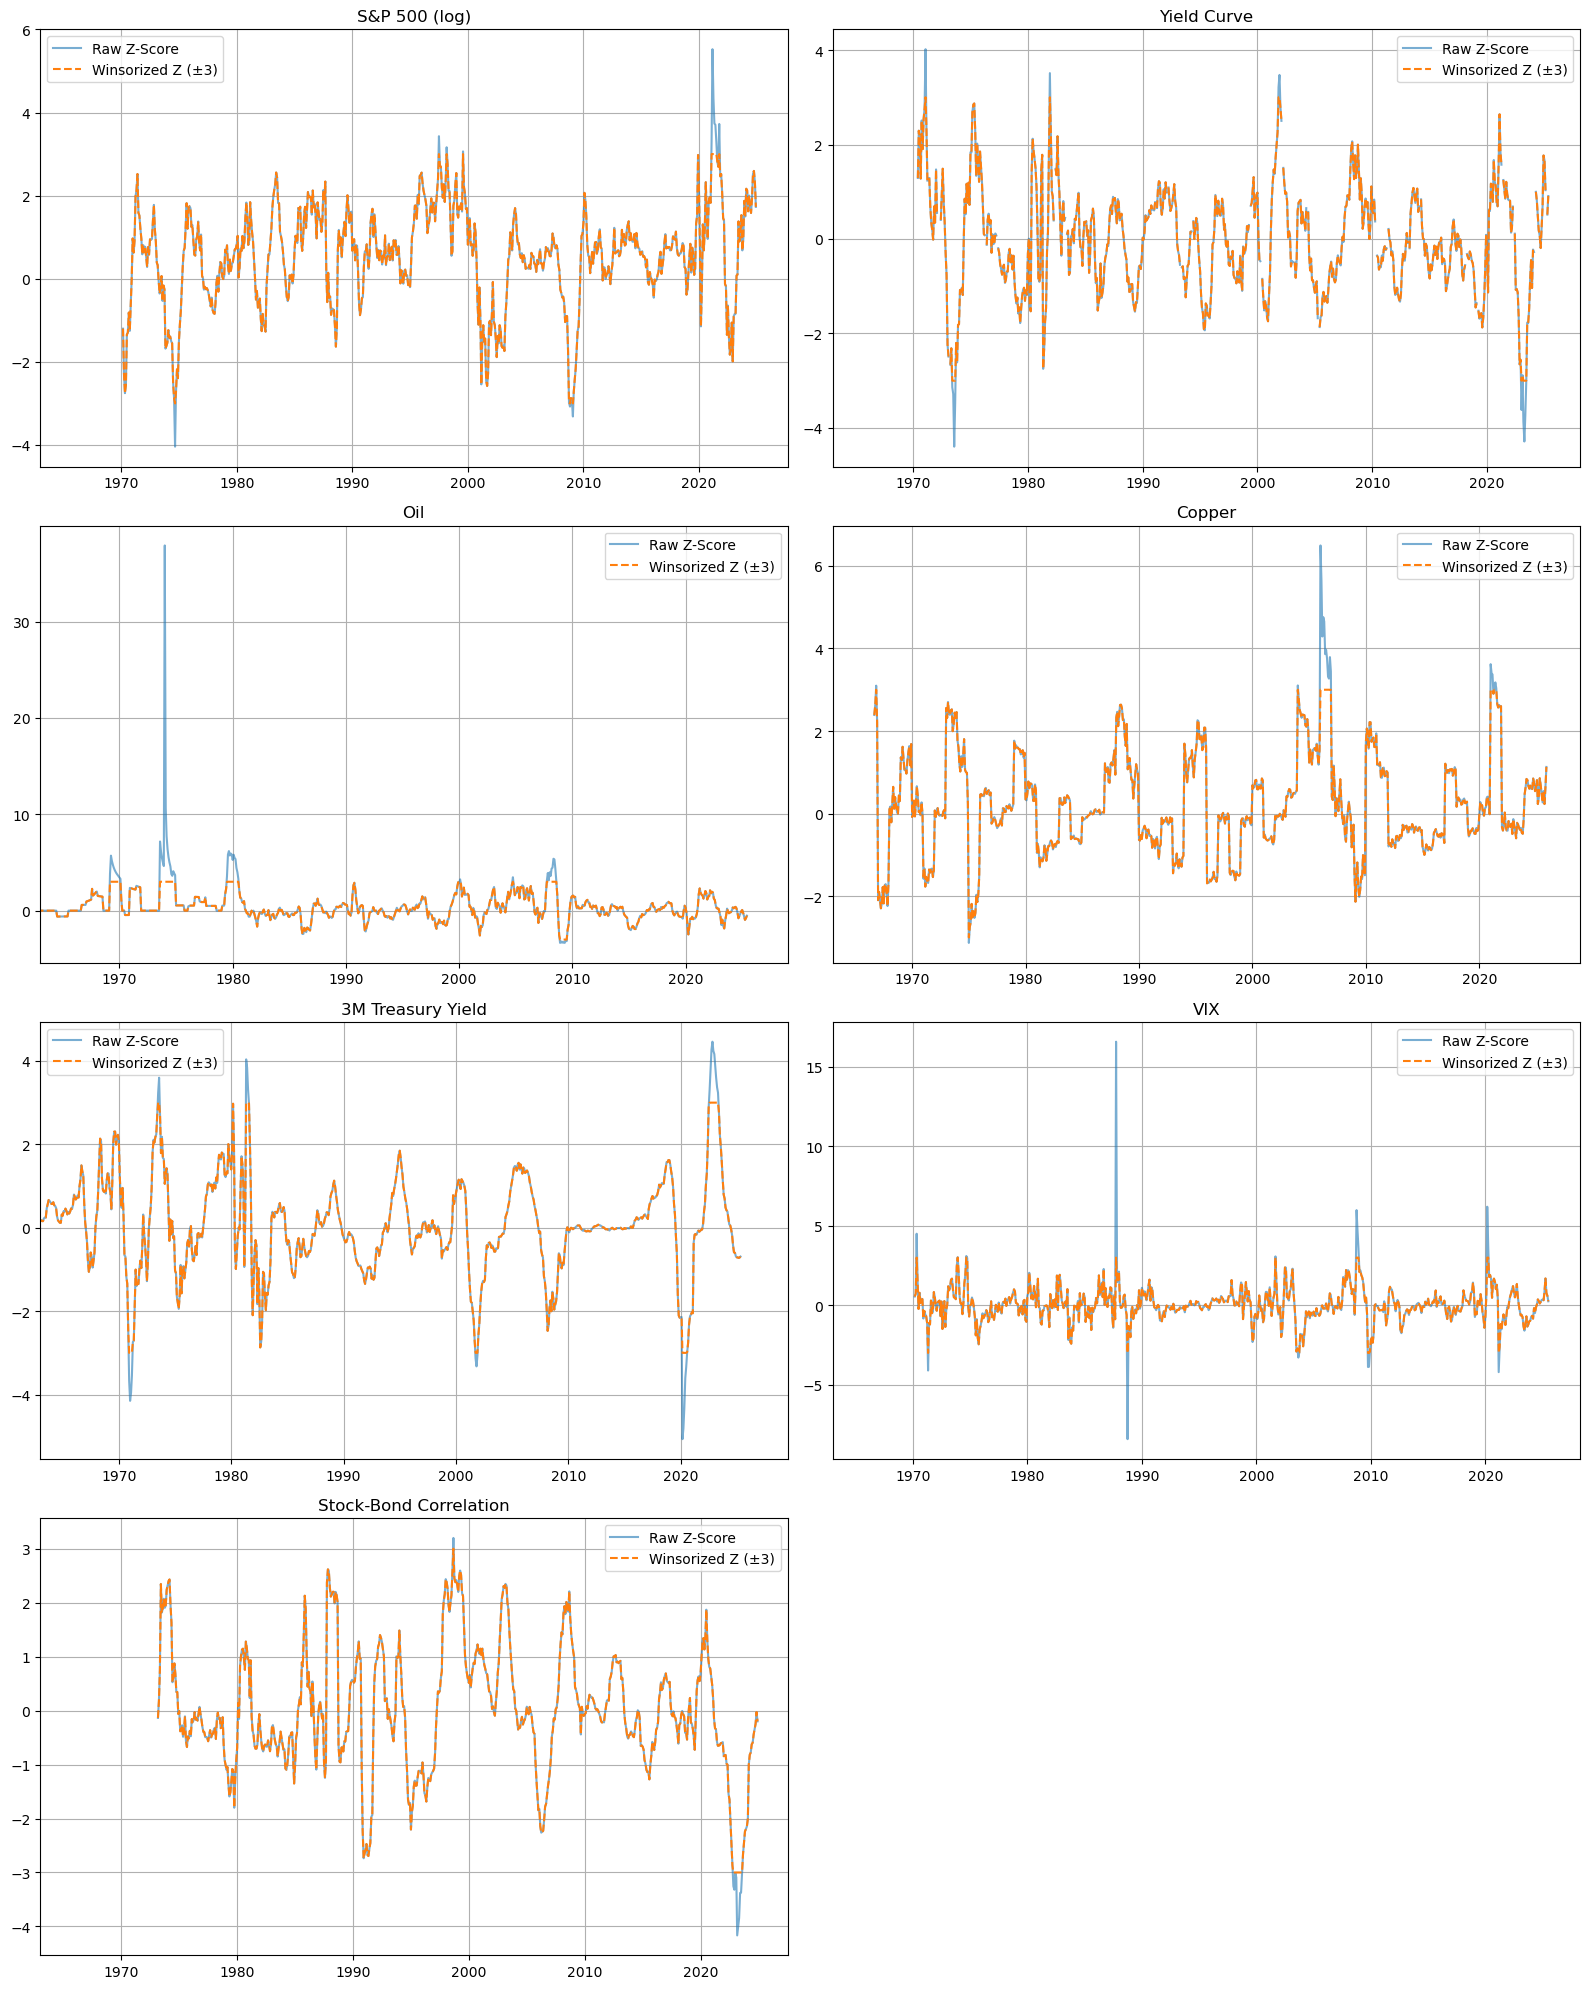

In [55]:
def compute_z_and_winsorized(df, date_col, value_col, window_months=120):
    df = df.copy().sort_values(date_col)
    df['Diff12'] = df[value_col] - df[value_col].shift(12)
    df['RollStd'] = df['Diff12'].shift(1).rolling(window_months,min_periods=80).std()
    df['ZScore'] = df['Diff12'] / df['RollStd']
    df['ZScoreWinsorized'] = df['ZScore'].clip(-3, 3)
    return df[[date_col, 'ZScore', 'ZScoreWinsorized']]


series_info = {
    'S&P 500 (log)':         ('sp500_log',      var_mkt,      'Month', 'Log_SP500'),
    'Yield Curve':           ('yield_curve',    merged,         'Month', 'YieldCurve'),
    'Oil':                   ('oil',            oil_monthly,    'Month', 'Oil Price'),
    'Copper':                ('copper',         copper_monthly, 'Month', 'Copper'),
    '3M Treasury Yield':     ('three_month',    var_3m,     'Month', 'ThreeMonth'),
    'VIX':                   ('vix',            combined_vol,   'Month', 'VolProxy'),
    'Stock-Bond Correlation':('stockbond_corr', var_correl,     'Month', 'StockBondCorr'),
}

fig, axes = plt.subplots(4, 2, figsize=(16, 20))
axes = axes.flatten()

for i, (title, (_, df, date_col, value_col)) in enumerate(series_info.items()):
    z_df = compute_z_and_winsorized(df, date_col, value_col)
    axes[i].plot(z_df[date_col].dt.to_timestamp(), z_df['ZScore'], label='Raw Z-Score', alpha=0.6)
    axes[i].plot(z_df[date_col].dt.to_timestamp(), z_df['ZScoreWinsorized'], label='Winsorized Z (±3)',ls = '--')
    axes[i].set_title(title)
    axes[i].set_xlim(left=pd.Timestamp('1963-01-01'))
    axes[i].grid(True)
    axes[i].legend()

for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


In [60]:

market_monthly = (var_mkt
                  .loc[:, ["Month", "Log_SP500"]]
                  .rename(columns={"Log_SP500": "Value"}))

yield_monthly = (merged
                 .loc[:, ["Month", "YieldCurve"]]
                 .rename(columns={"YieldCurve": "Value"}))

oil_monthly_clean = oil_monthly.rename(columns={"Oil Price": "Value"})

copper_monthly_clean = copper_monthly.rename(columns={"Copper": "Value"})

monthly_3m = (var_3m
              .loc[:, ["Month", "ThreeMonth"]]
              .rename(columns={"ThreeMonth": "Value"}))

vix_monthly_clean = combined_vol.rename(columns={"VolProxy": "Value"})

stockbond_monthly = (var_correl
                     .loc[:, ["Month", "StockBondCorr"]]
                     .rename(columns={"StockBondCorr": "Value"}))


series_dict = {
    'Market':               market_monthly, 
    'Yield curve':          yield_monthly,
    'Oil':                  oil_monthly_clean,
    'Copper':               copper_monthly_clean,
    '3M Treasury Yield':    monthly_3m,
    'VIX':                  vix_monthly_clean,
    'Stock-Bond Corr':      stockbond_monthly
}




rows = []
lags = [1, 3, 12, 36, 120]

for i, (title, (_, df, date_col, value_col)) in enumerate(series_info.items()):

    zdf = compute_z_and_winsorized(df, date_col, value_col).dropna(subset=['ZScoreWinsorized']).reset_index(drop=True)
    
    if len(zdf) < max(lags) + 1:
        acs = [np.nan] * len(lags)
        mean_z = np.nan
        std_z = np.nan
    else:
        acs = [zdf['ZScoreWinsorized'].autocorr(lag=lag) for lag in lags]
        mean_z = zdf['ZScoreWinsorized'].mean()
        std_z = zdf['ZScoreWinsorized'].std(ddof=1)  
    
    rows.append({
        'Variable':    title,
        '1 month':     acs[0],
        '3 month':     acs[1],
        '12 month':    acs[2],
        '3 year':      acs[3],
        '10 year':     acs[4],
        'monthly mean': mean_z,
        'std':          std_z,
        'frequency':   'monthly'
    })


summary_table = pd.DataFrame(rows)

summary_table = summary_table[
    ['Variable', '1 month', '3 month', '12 month', '3 year', '10 year',
     'monthly mean', 'std', 'frequency']
]

numeric_cols = ['1 month', '3 month', '12 month', '3 year', '10 year', 'monthly mean', 'std']
summary_table[numeric_cols] = summary_table[numeric_cols].round(2)

summary_table




,Variable,1 month,3 month,12 month,3 year,10 year,monthly mean,std,frequency
0,S&P 500 (log),0.92,0.78,0.02,0.05,0.01,0.54,1.16,monthly
1,Yield Curve,0.90,0.71,-0.13,-0.20,-0.01,-0.03,1.11,monthly
2,Oil,0.93,0.73,-0.04,0.15,-0.02,0.33,1.19,monthly
3,Copper,0.91,0.75,0.08,-0.08,0.02,0.22,1.19,monthly
4,3M Treasury Yield,0.96,0.82,0.02,-0.18,0.06,0.19,1.24,monthly
5,VIX,0.72,0.38,-0.32,-0.09,0.04,0.03,0.99,monthly
6,Stock-Bond Correlation,0.96,0.83,0.13,-0.36,0.12,-0.00,1.16,monthly


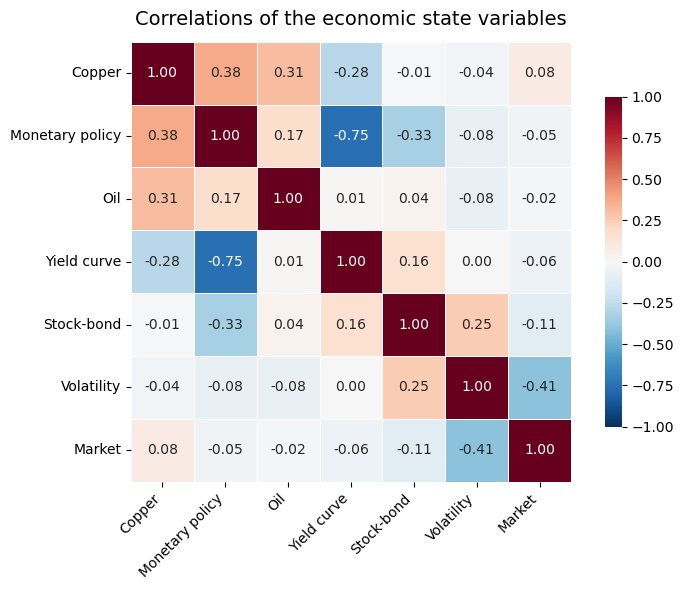

In [63]:
z_market  = compute_z_and_winsorized(market_monthly,      'Month', 'Value',          window_months=120) \
                .rename(columns={'ZScoreWinsorized':'Market'})[['Month','Market']]

z_yield   = compute_z_and_winsorized(yield_monthly,       'Month', 'Value',          window_months=120) \
                .rename(columns={'ZScoreWinsorized':'Yield curve'})[['Month','Yield curve']]

z_oil     = compute_z_and_winsorized(oil_monthly_clean,   'Month', 'Value',          window_months=120) \
                .rename(columns={'ZScoreWinsorized':'Oil'})[['Month','Oil']]

z_copper  = compute_z_and_winsorized(copper_monthly_clean,'Month', 'Value',          window_months=120) \
                .rename(columns={'ZScoreWinsorized':'Copper'})[['Month','Copper']]

z_3m      = compute_z_and_winsorized(monthly_3m,          'Month', 'Value',          window_months=120) \
                .rename(columns={'ZScoreWinsorized':'Monetary policy'})[['Month','Monetary policy']]

z_vix     = compute_z_and_winsorized(vix_monthly_clean,    'Month', 'Value',          window_months=120) \
                .rename(columns={'ZScoreWinsorized':'Volatility'})[['Month','Volatility']]

z_sb      = compute_z_and_winsorized(stockbond_monthly,    'Month', 'Value',  window_months=120) \
                .rename(columns={'ZScoreWinsorized':'Stock-bond'})[['Month','Stock-bond']]

df_period = (
    z_market
    .merge(z_yield, on='Month', how='outer')
    .merge(z_oil, on='Month', how='outer')
    .merge(z_copper, on='Month', how='outer')
    .merge(z_3m, on='Month', how='outer')
    .merge(z_vix, on='Month', how='outer')
    .merge(z_sb, on='Month', how='outer')
)


corr_mat = df_period.drop(columns='Month').corr()


row_order = [
    'Copper',
    'Monetary policy',
    'Oil',
    'Yield curve',
    'Stock-bond',
    'Volatility',
    'Market'
]
corr_mat = corr_mat.loc[row_order, row_order]

plt.figure(figsize=(8, 6))
sns.heatmap(
    corr_mat,
    annot=True,
    fmt='.2f',
    center=0,
    cmap='RdBu_r',
    vmin=-1,
    vmax=1,
    square=True,
    linewidths=0.5,
    cbar_kws={'shrink': 0.75}
)
plt.title('Correlations of the economic state variables', fontsize=14, pad=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [64]:
def find_similar_months(
    df_period: pd.DataFrame,
    target: str,
    exclude_last_n: int = 36,
    bottom_pct: float = 0.15
) -> pd.DataFrame:
    
    T_period = pd.Period(target, freq='M')

    
    cutoff_period = T_period - exclude_last_n  

    mask = df_period.index <= cutoff_period

    df_candidates = df_period.loc[mask].copy()

    df_candidates = df_candidates.dropna(how='any')

    z_T = df_period.loc[T_period].values   

    mat = df_candidates.values               
    diffs = mat - z_T.reshape(1, -1)        
    sq    = diffs**2
    dist  = np.sqrt(sq.sum(axis=1))          

    out = pd.DataFrame({
        'Distance': dist
    }, index=df_candidates.index)

    out = out.sort_values('Distance', ascending=True)
    out['Rank'] = np.arange(1, len(out) + 1)

    n_select = int(np.floor(bottom_pct * len(out)))
    n_select = max(n_select, 1)  # ensure at least one month is selected
    out['IsBottom'] = False
    out.iloc[:n_select, out.columns.get_indexer(['IsBottom'])] = True

    result_df = out.reset_index().rename(columns={'index': 'Month'})

    return result_df

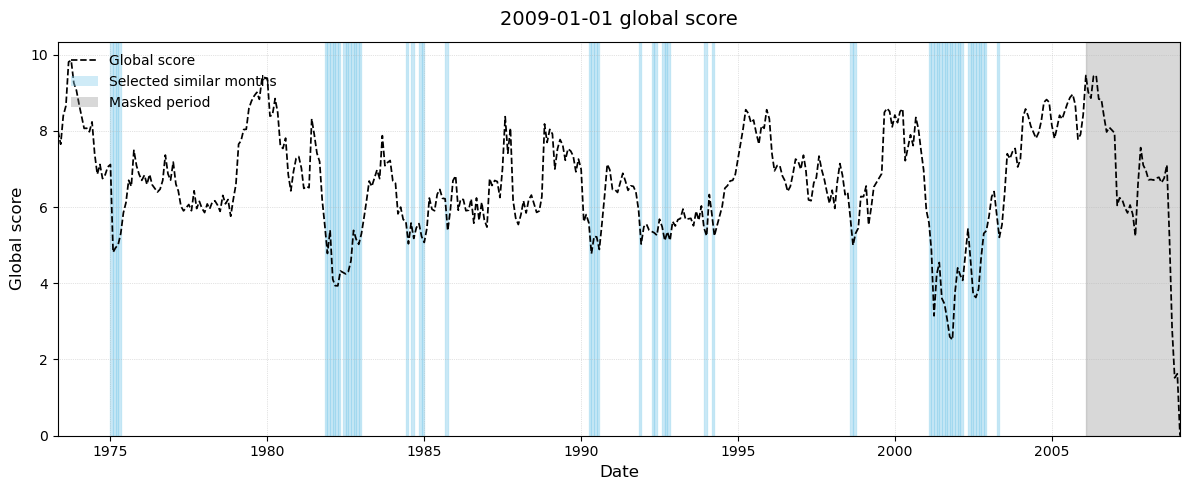

In [65]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.patches import Rectangle


target_month   = '2009-01'   
bottom_pct     = 0.15       
exclude_last_n = 36          

if 'Month' in df_period.columns:
    df_period = df_period.set_index('Month')


sim_tbl_full = find_similar_months(       
    df_period=df_period,
    target=target_month,
    exclude_last_n=0,          
    bottom_pct=bottom_pct,
)

sim_tbl_masked = find_similar_months(     
    df_period=df_period,
    target=target_month,
    exclude_last_n=exclude_last_n,
    bottom_pct=bottom_pct,
)

ts_dist = (
    sim_tbl_full.set_index('Month')['Distance']
               .sort_index()
               .rename('Global score')
)
ts_dist.index = ts_dist.index.to_timestamp(how='end')

selected = sim_tbl_masked[sim_tbl_masked['IsBottom']].copy()
selected['start'] = selected['Month'].dt.to_timestamp(how='start')
selected['end']   = selected['Month'].dt.to_timestamp(how='end')

T_period      = pd.Period(target_month, freq='M')
cutoff_period = T_period - exclude_last_n
mask_start_ts = (cutoff_period + 1).to_timestamp(how='start')
mask_end_ts   = T_period.to_timestamp(how='end')


plt.figure(figsize=(12, 5))
ax = plt.gca()

ax.plot(ts_dist.index, ts_dist.values,
        linestyle='--', color='black', linewidth=1.25,
        label='Global score')

for _, row in selected.iterrows():
    ax.axvspan(row['start'], row['end'], color='skyblue', alpha=0.4)

ax.axvspan(mask_start_ts, mask_end_ts, color='gray', alpha=0.3)

proxy_sim  = Rectangle((0, 0), 1, 1, facecolor='skyblue', alpha=0.4)
proxy_mask = Rectangle((0, 0), 1, 1, facecolor='gray',    alpha=0.3)
ax.legend(handles=[ax.lines[0], proxy_sim, proxy_mask],
          labels=['Global score', 'Selected similar months', 'Masked period'],
          loc='upper left', frameon=False)

ax.set_title('2009-01-01 global score', fontsize=14, pad=12)
ax.set_ylabel('Global score', fontsize=12)
ax.set_xlabel('Date', fontsize=12)
ax.set_ylim(bottom=0)           
ax.set_xlim(left=ts_dist.index.min(),
            right=ts_dist.index.max()) 

ax.grid(which='major', linestyle=':', linewidth=0.5, alpha=0.7)
ax.xaxis.set_major_locator(mdates.YearLocator(base=5))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=0)

plt.tight_layout()
plt.show()



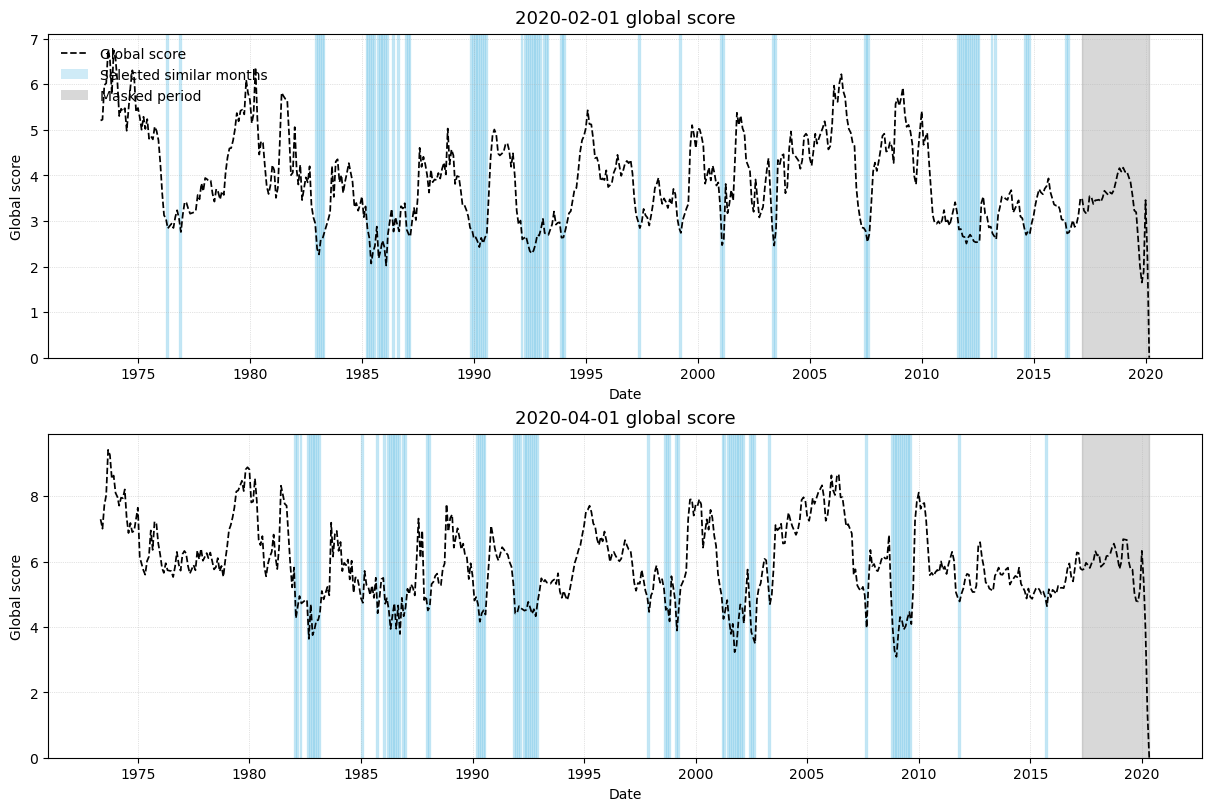

In [66]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.patches import Rectangle


targets        = ['2020-02', '2020-04']  
bottom_pct     = 0.15                    
exclude_last_n = 36                       

if 'Month' in df_period.columns:
    df_period = df_period.set_index('Month')


fig, axes = plt.subplots(
    nrows=2, ncols=1, figsize=(12, 8), sharey=False, constrained_layout=True
)

for ax, tgt_str in zip(axes, targets):

    sim_full = find_similar_months(df_period, tgt_str, exclude_last_n=0,
                                   bottom_pct=bottom_pct)
    ts_dist = (sim_full.set_index('Month')['Distance']
                       .sort_index()
                       .rename('Global score'))
    ts_dist.index = ts_dist.index.to_timestamp(how='end')

    sim_masked = find_similar_months(df_period, tgt_str,
                                     exclude_last_n=exclude_last_n,
                                     bottom_pct=bottom_pct)
    selected = sim_masked[sim_masked['IsBottom']].copy()
    selected['start'] = selected['Month'].dt.to_timestamp(how='start')
    selected['end']   = selected['Month'].dt.to_timestamp(how='end')

    Tp          = pd.Period(tgt_str, freq='M')
    mask_start  = (Tp - exclude_last_n + 1).to_timestamp(how='start')
    mask_end    = Tp.to_timestamp(how='end')

    ax.plot(ts_dist.index, ts_dist.values, '--', color='black', lw=1.25)

    for _, row in selected.iterrows():
        ax.axvspan(row['start'], row['end'], color='skyblue', alpha=0.4)

    ax.axvspan(mask_start, mask_end, color='gray', alpha=0.3)

    ax.set_ylim(bottom=0)                     
    ax.set_title(f'{tgt_str}-01 global score', fontsize=13, pad=8)
    ax.set_xlabel('Date')
    ax.set_ylabel('Global score')
    ax.grid(which='major', linestyle=':', linewidth=0.5, alpha=0.7)
    ax.xaxis.set_major_locator(mdates.YearLocator(base=5))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

proxy_sim  = Rectangle((0, 0), 1, 1, facecolor='skyblue', alpha=0.4)
proxy_mask = Rectangle((0, 0), 1, 1, facecolor='gray',    alpha=0.3)
axes[0].legend([axes[0].lines[0], proxy_sim, proxy_mask],
               ['Global score', 'Selected similar months', 'Masked period'],
               loc='upper left', frameon=False)

plt.show()



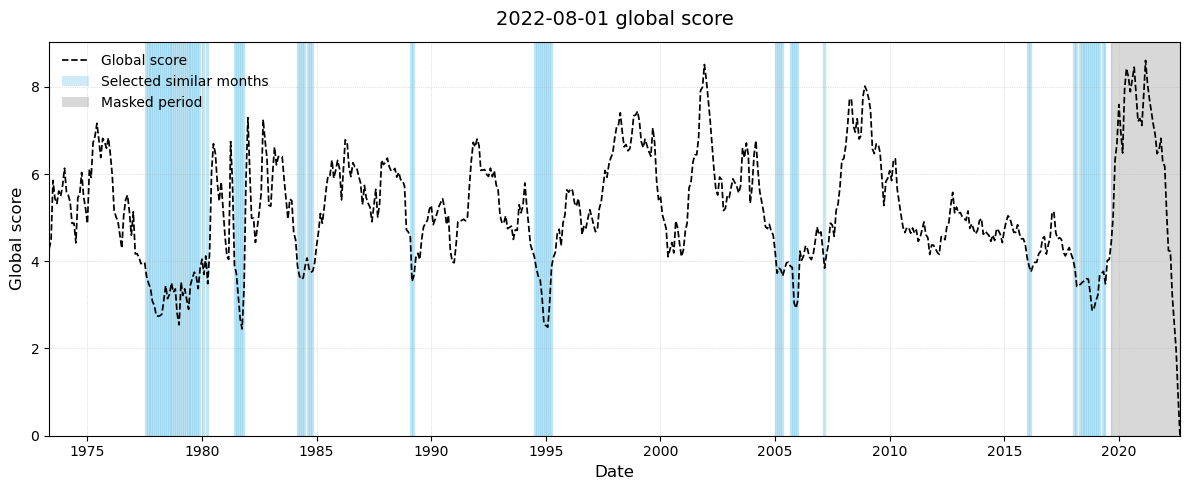

In [67]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.patches import Rectangle

target_month   = '2022-08'     
bottom_pct     = 0.15          
exclude_last_n = 36           

if 'Month' in df_period.columns:
    df_period = df_period.set_index('Month')


sim_full = find_similar_months(
    df_period=df_period,
    target=target_month,
    exclude_last_n=0,            
    bottom_pct=bottom_pct,
)
ts_dist = (sim_full.set_index('Month')['Distance']
                    .sort_index()
                    .rename('Global score'))
ts_dist.index = ts_dist.index.to_timestamp(how='end')

sim_masked = find_similar_months(
    df_period=df_period,
    target=target_month,
    exclude_last_n=exclude_last_n,
    bottom_pct=bottom_pct,
)
selected = sim_masked[sim_masked['IsBottom']].copy()
selected['start'] = selected['Month'].dt.to_timestamp(how='start')
selected['end']   = selected['Month'].dt.to_timestamp(how='end')

Tp          = pd.Period(target_month, freq='M')
mask_start  = (Tp - exclude_last_n + 1).to_timestamp(how='start')
mask_end    = Tp.to_timestamp(how='end')


plt.figure(figsize=(12, 5))
ax = plt.gca()

ax.plot(ts_dist.index, ts_dist.values,
        linestyle='--', color='black', linewidth=1.25,
        label='Global score')

for _, row in selected.iterrows():
    ax.axvspan(row['start'], row['end'], color='skyblue', alpha=0.4)

ax.axvspan(mask_start, mask_end, color='gray', alpha=0.3)

proxy_sim  = Rectangle((0, 0), 1, 1, facecolor='skyblue', alpha=0.4)
proxy_mask = Rectangle((0, 0), 1, 1, facecolor='gray',    alpha=0.3)
ax.legend([ax.lines[0], proxy_sim, proxy_mask],
          ['Global score', 'Selected similar months', 'Masked period'],
          loc='upper left', frameon=False)

ax.set_title('2022-08-01 global score', fontsize=14, pad=12)
ax.set_ylabel('Global score', fontsize=12)
ax.set_xlabel('Date', fontsize=12)
ax.set_ylim(bottom=0)                            
ax.set_xlim(left=ts_dist.index.min(),
            right=ts_dist.index.max())            
ax.grid(which='major', linestyle=':', linewidth=0.5, alpha=0.7)
ax.xaxis.set_major_locator(mdates.YearLocator(base=5))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=0)

plt.tight_layout()
plt.show()



In [68]:
ff_5f = pd.read_csv(r"C:\Users\kelvi\Downloads\F-F_Research_Data_5_Factors_2x3_CSV (2)\F-F_Research_Data_5_Factors_2x3.csv")
ff_mom = pd.read_csv(r"C:\Users\kelvi\Downloads\F-F_Momentum_Factor_CSV (1)\F-F_Momentum_Factor.csv")

In [69]:
concat_fff = pd.merge(ff_5f, ff_mom, on='Unnamed: 0', how='inner')
concat_fff.rename(columns={'Unnamed: 0': 'Date'}, inplace = True)

mask_valid = concat_fff['Date'].astype(str).str.match(r'^\d{6}$')
concat_fff = concat_fff.loc[mask_valid].copy()

concat_fff['Date'] = concat_fff['Date'].astype(str)
concat_fff['Month'] = concat_fff['Date'].apply(lambda x: pd.Period(x, freq='M'))
factor_cols = ['Mkt-RF','SMB','HML','RMW','CMA','Mom']
for col in factor_cols:
    concat_fff[col] = pd.to_numeric(concat_fff[col], errors='coerce') / 100.0

concat_fff['RF'] = pd.to_numeric(concat_fff['RF'], errors='coerce') / 100.0
concat_fff = concat_fff.set_index('Month')
concat_fff.drop(columns=['Date'], inplace=True)
concat_fff.head()

,Mkt-RF,SMB,HML,RMW,CMA,RF,Mom
Month,,,,,,,
1963-07,-0.0039,-0.0048,-0.0081,0.0064,-0.0115,0.0027,0.0101
1963-08,0.0508,-0.0080,0.0170,0.0040,-0.0038,0.0025,0.0100
1963-09,-0.0157,-0.0043,0.0000,-0.0078,0.0015,0.0027,0.0012
1963-10,0.0254,-0.0134,-0.0004,0.0279,-0.0225,0.0029,0.0313
1963-11,-0.0086,-0.0085,0.0173,-0.0043,0.0227,0.0027,-0.0078


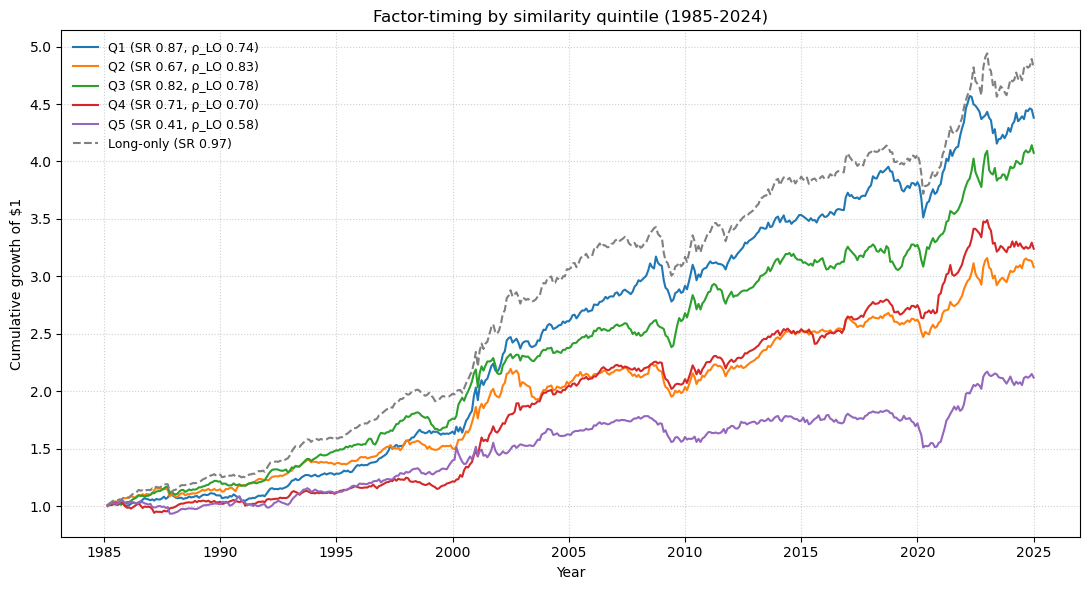

In [71]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

lookback_gap  = 36                             
factors       = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'Mom']
colors        = {1:"tab:blue", 2:"tab:orange", 3:"tab:green",
                 4:"tab:red", 5:"tab:purple"}

BACKTEST_START = pd.Period('1985-01', freq='M')
BACKTEST_END   = pd.Period('2024-12', freq='M')

def quintile_members(df_period: pd.DataFrame, target_per: pd.Period):
    """
    Return dict{1…5 → ndarray of months} following the paper’s rules:
      • Q1 = closest 20 %
      • Q5 = farthest 20 %
      • Q2-Q4 = equal thirds of the middle 60 %
    """
    full = find_similar_months(
        df_period      = df_period,
        target         = str(target_per),
        exclude_last_n = lookback_gap,
        bottom_pct     = 1.0             
    ).sort_values("Distance")            

    n = len(full)
    if n == 0:                          
        return {q: np.array([]) for q in range(1, 6)}

    k20 = int(0.20 * n)
    q1  = full.iloc[:k20]['Month'].to_numpy()
    q5  = full.iloc[-k20:]['Month'].to_numpy()

    mid = full.iloc[k20:-k20]['Month'].to_numpy()
    q2, q3, q4 = np.array_split(mid, 3)

    return {1: q1, 2: q2, 3: q3, 4: q4, 5: q5}

def signal_for_quintile(df_period, target_per, quintile):
    months = quintile_members(df_period, target_per)[quintile]
    if len(months) == 0:
        return {f: 0 for f in factors}

    idx = pd.PeriodIndex(months, freq="M") + 1         
    signs = {}
    for f in factors:
        rets = concat_fff.loc[concat_fff.index.intersection(idx), f]
        signs[f] = np.sign(rets.mean()) if not rets.empty else 0
    return signs

first_possible = df_period.index.min() + (lookback_gap + 1)
hist_start     = max(BACKTEST_START, first_possible)
hist_end       = min(BACKTEST_END,   concat_fff.index.max())

all_months = concat_fff.index.sort_values()
start_idx  = next(i for i, per in enumerate(all_months) if per >= hist_start)
stop_idx   = next(i for i, per in enumerate(all_months) if per >  hist_end) - 1

returns_by_q = {q: [] for q in range(1, 6)}

for i in range(start_idx, stop_idx):
    cur_per = all_months[i]
    nxt_per = all_months[i + 1]
    r       = concat_fff.loc[nxt_per, factors]

    for q in range(1, 6):
        sig = signal_for_quintile(df_period, cur_per, q)
        ret = np.mean([sig[f] * r[f] for f in factors])
        returns_by_q[q].append({"Date": nxt_per, "Return": ret})

q_df = {q: pd.DataFrame(lst).set_index("Date") for q, lst in returns_by_q.items()}

long_only = concat_fff[factors].mean(axis=1).loc[q_df[1].index]

ann_sr  = lambda x: (x.mean() / x.std()) * np.sqrt(12) if x.std() != 0 else np.nan
corr_lo = lambda x: x.corr(long_only)

stats = {q: (ann_sr(df["Return"]), corr_lo(df["Return"])) for q, df in q_df.items()}
sr_lo = ann_sr(long_only)

cum = lambda x: (1 + x).cumprod()

plt.figure(figsize=(11, 6))
for q in range(1, 6):
    plt.plot(q_df[q].index.to_timestamp(how="end"),
             cum(q_df[q]["Return"]),
             color=colors[q],
             label=f"Q{q} (SR {stats[q][0]:.2f}, ρ_LO {stats[q][1]:.2f})")

plt.plot(q_df[1].index.to_timestamp(how="end"),
         cum(long_only), color="gray", ls="--",
         label=f"Long-only (SR {sr_lo:.2f})")

plt.title("Factor-timing by similarity quintile (1985-2024)")
plt.xlabel("Year")
plt.ylabel("Cumulative growth of $1")
plt.legend(frameon=False, fontsize=9)
plt.grid(ls=":", alpha=.6)
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator(base=5))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
plt.tight_layout()
plt.show()


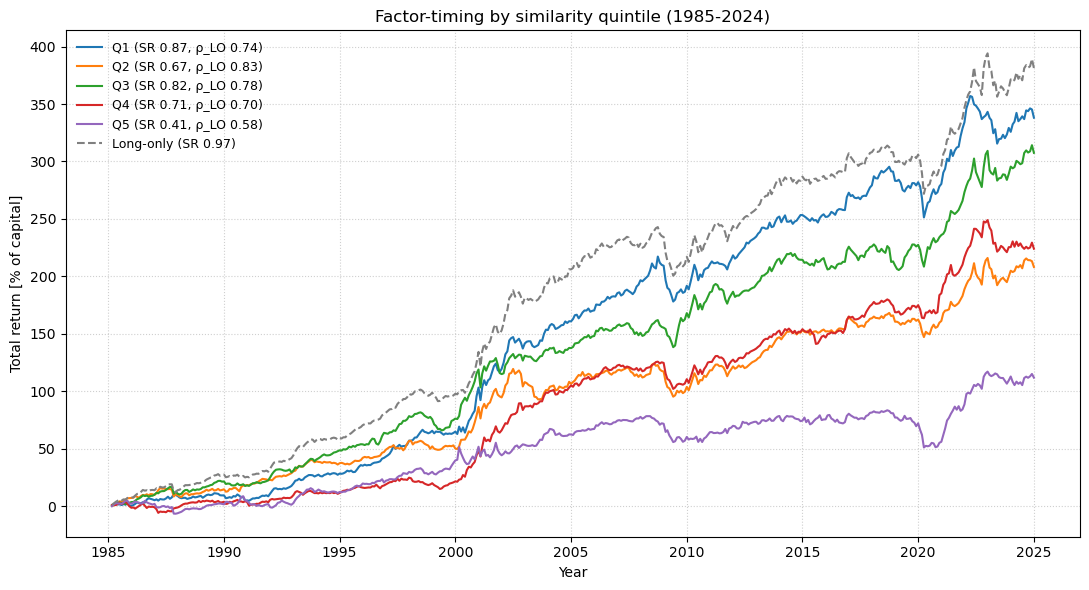

In [76]:
cum_pct = lambda x: ((1 + x).cumprod() - 1) * 100      
plt.figure(figsize=(11, 6))
for q in range(1, 6):
    plt.plot(q_df[q].index.to_timestamp(how="end"),
             cum_pct(q_df[q]["Return"]),
             color=colors[q],
             label=f"Q{q} (SR {stats[q][0]:.2f}, ρ_LO {stats[q][1]:.2f})")

plt.plot(q_df[1].index.to_timestamp(how="end"),
         cum_pct(long_only), color="gray", ls="--",
         label=f"Long-only (SR {sr_lo:.2f})")

plt.title("Factor-timing by similarity quintile (1985-2024)")
plt.xlabel("Year")
plt.ylabel("Total return [% of capital]")
plt.legend(frameon=False, fontsize=9)
plt.grid(ls=":", alpha=.6)

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator(base=5))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
plt.tight_layout()
plt.show()


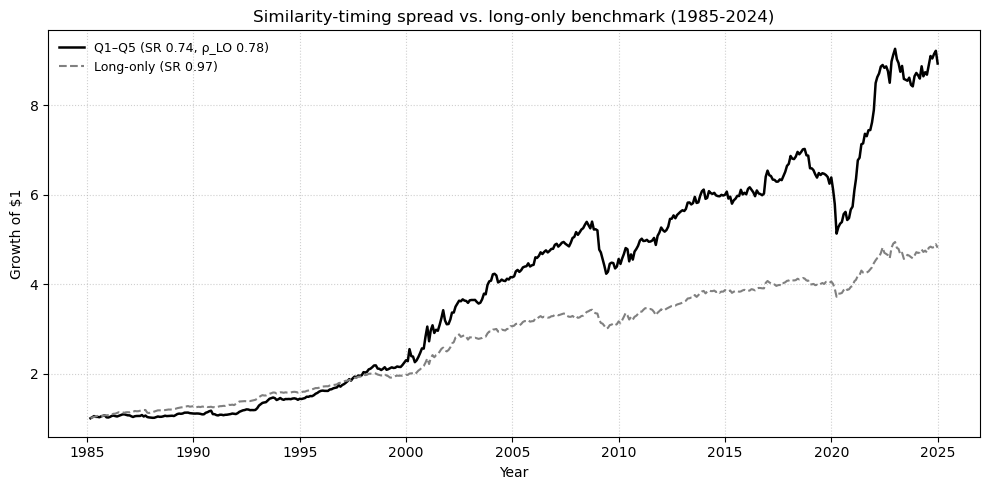

In [75]:

q_spread = q_df[1]["Return"] - q_df[5]["Return"]
q_spread.name = "Q1–Q5"

ann_sr = lambda x: (x.mean() / x.std(ddof=1)) * np.sqrt(12)

sr_spread   = ann_sr(q_spread)
corr_spread = q_spread.corr(long_only.reindex_like(q_spread))

cum = lambda x: (1 + x).cumprod()
time = q_spread.index.to_timestamp(how="end")

plt.figure(figsize=(10, 5))

plt.plot(time,
         cum(q_spread),
         color="black", lw=1.8,
         label=f"Q1–Q5 (SR {sr_spread:.2f}, ρ_LO {corr_spread:.2f})")

plt.plot(time,
         cum(long_only.reindex_like(q_spread)),
         color="gray", ls="--",
         label=f"Long-only (SR {sr_lo:.2f})")

plt.title("Similarity-timing spread vs. long-only benchmark (1985-2024)")
plt.xlabel("Year")
plt.ylabel("Growth of $1")
plt.grid(ls=":", alpha=.6)
plt.legend(frameon=False, fontsize=9)

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator(base=5))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
plt.tight_layout()
plt.show()

